## Nanophotonic natural language processing

In [1]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 100, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [2]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

Nouns: Alice, Bob, Claire, Dave, Eve, Fred
Verbs: loves, kills, hates


108 subject-verb-object sentences:


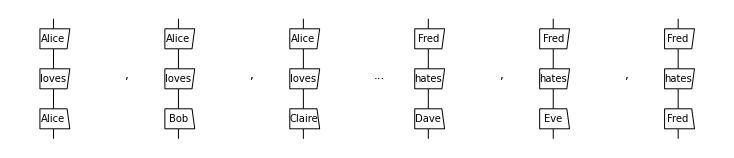

In [3]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [34]:
import numpy as np; 

from discopy.quantum.optics_vienna import Id, MZI
from discopy.quantum.optics_vienna import Functor

def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

Ansatz for 'Bob' (6 parameters):


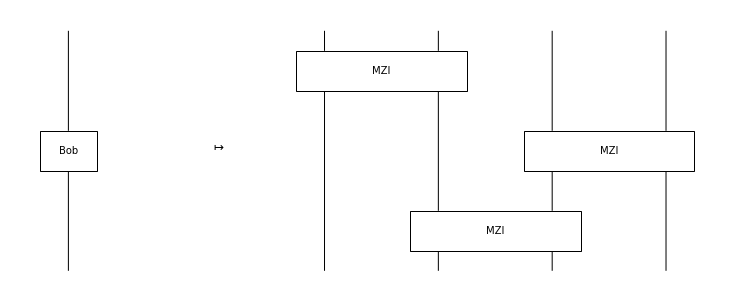

Total: 9 * 6 = 54 parameters.
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]


In [39]:
n_params = 2 * (depth * width // 2 - depth // 2)

np.random.seed(SEED);
random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

Ansatz for 'Alice loves Bob':


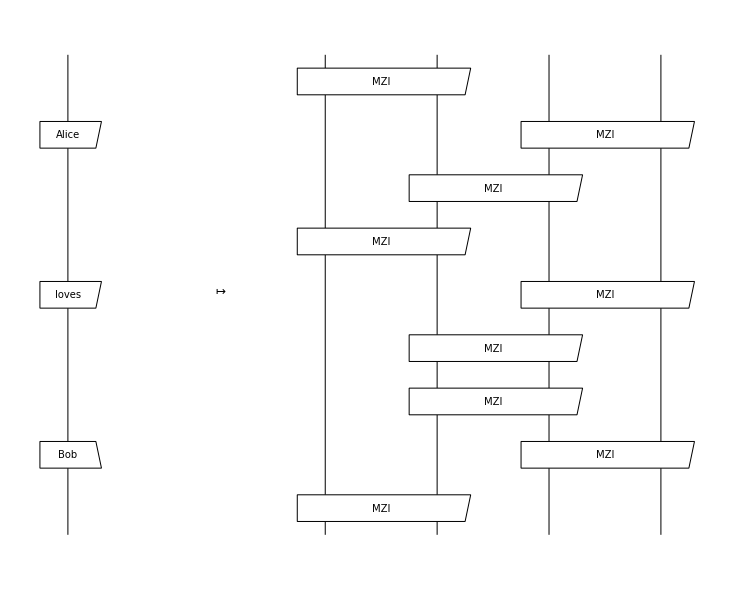

In [40]:
F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

In [41]:
# probability = lambda amplitude: np.absolute(amplitude) ** 2
activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

def evaluate(params, sentence, mode='boson'):
    params = params.reshape(params0.shape)
    if mode=='boson':
        return post_processing(
            F(params)(corpus[sentence]).prob_boson(
                input_modes, output_modes))
    if mode=='distinguish':
        return post_processing(
            F(params)(corpus[sentence]).prob_distinguish(
                input_modes, output_modes))
    if mode=='classical':
        return post_processing(
            F(params)(corpus[sentence]).prob_classical(
                input_modes, output_modes))
    if mode=='coherent':
        return post_processing(
            F(params)(corpus[sentence]).prob_coherent(
                input_modes, output_modes))
    

%time scores = {sentence: evaluate(params0, sentence, mode='coherent') for sentence in corpus}

print("Does Alice love Bob? {} ({:.2F})".format(
    "Yes" if scores["Alice loves Bob"] > .5 else "No", scores["Alice loves Bob"]))

Wall time: 3.41 s
Does Alice love Bob? Yes (0.90)


Min: 0.72 (Eve kills Fred)
Max: 0.98 (Fred hates Alice)
Mean: 0.92
Standard deviation: 0.05

108 true sentences (score > .5)


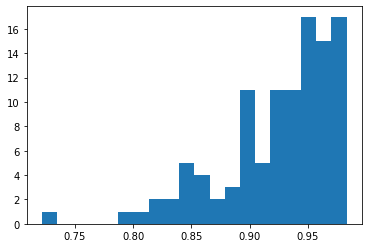

In [42]:
from matplotlib import pyplot as plt

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

Training set:
Bob kills Eve
Claire loves Eve
Alice loves Fred
...

Testing set:
Eve loves Fred
Alice kills Eve
Alice loves Eve
...



In [47]:
def loss(corpus, params, mode='boson'):
    return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence, mode=mode))
        for sentence in corpus]))

testing_loss = lambda params, mode: loss(test, params, mode)
training_loss = lambda params, mode: loss(train, params, mode)

np.random.seed(SEED);
params = random_params().flatten()

for mm in ['boson', 'classical', 'distinguish', 'coherent']:
    print(f'Mode {mm}')
    print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
        training_loss(params, mode=mm), testing_loss(params, mode=mm)))
    print(params)
    print()
    print("Does Alice love Bob?")
    print("Yes" if evaluate(params, 'Alice loves Bob') > .5 else "No")
    print()

Mode boson
Random initialisation, training_loss: 0.298, testing loss: 0.268
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]

Does Alice love Bob?
No

Mode classical
Random initialisation, training_loss: 0.033, testing loss: 0.039
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]

Does Alice love Bob?
No

Mode distinguish
Random initialisation, training_loss: 0.273, testing loss: 0.256
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]

Does Alice love Bob?
No

Mode coherent
Random initialisation, training_loss: 0.008, testing loss: 0.009
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]

Does Alice love Bob?
No



In [75]:
params

array([0.31564591, 0.45303068, 0.26698226, ..., 0.25445189, 0.35811394,
       0.50401754])

In [49]:
from noisyopt import minimizeSPSA
from time import time 
import copy

def callback_wrapper(mode='boson', training_losses=[], testing_losses=[]):
    def callback(params):
        training_losses.append(training_loss(params, mode))
        testing_losses.append(testing_loss(params, mode))
        if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
            print("Mode {}, Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
                mode, len(training_losses), training_losses[-1], testing_losses[-1]))
            print(params)
            print()
    return callback

In [54]:
# Boson
start = time()

params_boson = copy.deepcopy(params)
training_losses_boson, testing_losses_boson = [], []
    
result = minimizeSPSA(training_loss, params_boson, args={'boson'}, paired=False, \
    callback=callback_wrapper(mode='boson', training_losses=training_losses_boson, testing_losses=testing_losses_boson), niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Mode boson, Iteration 1, training_loss: 0.274, testing loss: 0.265
[0.39204264 0.37663395 0.34337899 ... 0.33084861 0.43451067 0.42762082]

Mode boson, Iteration 2, training_loss: 0.274, testing loss: 0.266
[0.40570353 0.36297307 0.3297181  ... 0.31718773 0.42084978 0.4412817 ]

Mode boson, Iteration 3, training_loss: 0.270, testing loss: 0.293
[0.3788744  0.33614393 0.30288897 ... 0.34401686 0.39402065 0.41445257]

Mode boson, Iteration 4, training_loss: 0.265, testing loss: 0.273
[0.35776018 0.35725814 0.32400318 ... 0.32290265 0.37290644 0.43556678]

Mode boson, Iteration 5, training_loss: 0.264, testing loss: 0.268
[0.36974622 0.36924418 0.31201715 ... 0.33488868 0.36092041 0.44755282]

Mode boson, Iteration 6, training_loss: 0.264, testing loss: 0.265
[0.353107   0.35260496 0.29537793 ... 0.31824946 0.37755962 0.46419203]

Mode boson, Iteration 7, training_loss: 0.266, testing loss: 0.255
[0.37873112 0.37822908 0.26975381 ... 0.34387358 0.40318374 0.48981615]

Mode boson, Iteratio

In [58]:
# distinguish
start = time()

params_distinguish = copy.deepcopy(params)
training_losses_distinguish, testing_losses_distinguish = [], []
    
result = minimizeSPSA(training_loss, params_distinguish, args={'distinguish'}, paired=False, \
    callback=callback_wrapper(mode='distinguish', training_losses=training_losses_distinguish, testing_losses=testing_losses_distinguish), niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Mode distinguish, Iteration 1, training_loss: 0.271, testing loss: 0.245
[0.35230324 0.41637335 0.30363959 ... 0.21779456 0.39477127 0.54067487]

Mode distinguish, Iteration 2, training_loss: 0.253, testing loss: 0.241
[0.29801975 0.36208985 0.2493561  ... 0.16351107 0.34048778 0.59495836]

Mode distinguish, Iteration 3, training_loss: 0.252, testing loss: 0.241
[0.297039   0.3630706  0.24837535 ... 0.16449181 0.33950703 0.59397762]

Mode distinguish, Iteration 4, training_loss: 0.252, testing loss: 0.240
[0.29617166 0.36393795 0.24750801 ... 0.16535916 0.34037438 0.59484496]

Mode distinguish, Iteration 5, training_loss: 0.252, testing loss: 0.240
[0.29648984 0.36361977 0.24782619 ... 0.16567734 0.34069256 0.59516314]

Mode distinguish, Iteration 6, training_loss: 0.258, testing loss: 0.237
[0.26845297 0.39165663 0.27586305 ... 0.19371421 0.31265569 0.62320001]

Mode distinguish, Iteration 7, training_loss: 0.258, testing loss: 0.237
[0.26675916 0.39335045 0.27755687 ... 0.19202039 0.

In [56]:
# classical
start = time()

params_classical = copy.deepcopy(params)
training_losses_classical, testing_losses_classical = [], []
    
result = minimizeSPSA(training_loss, params_classical, args={'classical'}, paired=False, \
    callback=callback_wrapper(mode='classical', training_losses=training_losses_classical, testing_losses=testing_losses_classical), niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Mode classical, Iteration 1, training_loss: 0.028, testing loss: 0.041
[0.28565625 0.42304101 0.29697193 ... 0.28444156 0.32812427 0.53400721]

Mode classical, Iteration 2, training_loss: 0.028, testing loss: 0.042
[0.28243272 0.42626454 0.2937484  ... 0.28766509 0.3313478  0.53723074]

Mode classical, Iteration 3, training_loss: 0.028, testing loss: 0.041
[0.28585137 0.42284588 0.29716706 ... 0.29108374 0.32792915 0.53381208]

Mode classical, Iteration 4, training_loss: 0.028, testing loss: 0.042
[0.29421433 0.43120884 0.2888041  ... 0.28272079 0.31956619 0.54217504]

Mode classical, Iteration 5, training_loss: 0.028, testing loss: 0.041
[0.29154769 0.42854219 0.29147075 ... 0.28005414 0.32223284 0.54484169]

Mode classical, Iteration 6, training_loss: 0.025, testing loss: 0.037
[0.27303743 0.44705244 0.2729605  ... 0.29856439 0.30372258 0.56335194]

Mode classical, Iteration 7, training_loss: 0.023, testing loss: 0.035
[0.28928791 0.46330292 0.28921097 ... 0.28231392 0.31997306 0.579

In [57]:
# coherent
start = time()

params_coherent = copy.deepcopy(params)
training_losses_coherent, testing_losses_coherent = [], []
    
result = minimizeSPSA(training_loss, params_coherent, args={'coherent'}, paired=False, \
    callback=callback_wrapper(mode='coherent', training_losses=training_losses_coherent, testing_losses=testing_losses_coherent), niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Mode coherent, Iteration 1, training_loss: 0.007, testing loss: 0.009
[0.30497752 0.46369907 0.25631387 ... 0.26512028 0.34744555 0.51468593]

Mode coherent, Iteration 2, training_loss: 0.007, testing loss: 0.009
[0.30138178 0.46010333 0.25990961 ... 0.26152454 0.34384981 0.51828168]

Mode coherent, Iteration 3, training_loss: 0.007, testing loss: 0.009
[0.31353957 0.44794554 0.24775182 ... 0.24936675 0.33169201 0.53043947]

Mode coherent, Iteration 4, training_loss: 0.007, testing loss: 0.009
[0.31243915 0.44904595 0.2466514  ... 0.25046717 0.33279243 0.52933905]

Mode coherent, Iteration 5, training_loss: 0.006, testing loss: 0.009
[0.30825413 0.45323098 0.25083642 ... 0.24628215 0.32860741 0.52515403]

Mode coherent, Iteration 6, training_loss: 0.005, testing loss: 0.008
[0.31925779 0.44222732 0.23983276 ... 0.25728581 0.33961107 0.51415036]

Mode coherent, Iteration 7, training_loss: 0.005, testing loss: 0.008
[0.31725259 0.44022212 0.24183796 ... 0.25528061 0.34161627 0.51214517]


Text(0.5, 0, 'Epoch')

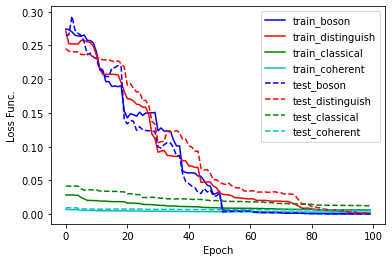

In [71]:
plt.plot(training_losses_boson, 'b-', label='train_boson')
plt.plot(training_losses_distinguish, 'r-', label='train_distinguish')
plt.plot(training_losses_classical, 'g-', label='train_classical')
plt.plot(training_losses_coherent, 'c-', label='train_coherent')

plt.plot(testing_losses_boson, 'b--', label='test_boson')
plt.plot(testing_losses_distinguish, 'r--', label='test_distinguish')
plt.plot(testing_losses_classical, 'g--', label='test_classical')
plt.plot(testing_losses_coherent, 'c--', label='test_coherent')

plt.legend()
plt.ylabel('Loss Func.')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

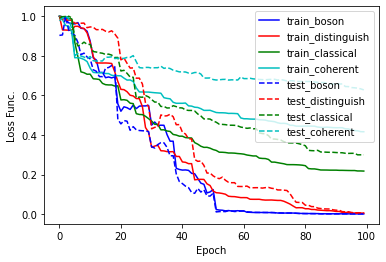

In [78]:
plt.plot(training_losses_boson/max(training_losses_boson), 'b-', label='train_boson')
plt.plot(training_losses_distinguish/max(training_losses_distinguish), 'r-', label='train_distinguish')
plt.plot(training_losses_classical/max(training_losses_classical), 'g-', label='train_classical')
plt.plot(training_losses_coherent/max(training_losses_coherent), 'c-', label='train_coherent')

plt.plot(testing_losses_boson/max(testing_losses_boson), 'b--', label='test_boson')
plt.plot(testing_losses_distinguish/max(testing_losses_distinguish), 'r--', label='test_distinguish')
plt.plot(testing_losses_classical/max(testing_losses_classical), 'g--', label='test_classical')
plt.plot(testing_losses_coherent/max(testing_losses_coherent), 'c--', label='test_coherent')

plt.legend()
plt.ylabel('Loss Func.')
plt.xlabel('Epoch')

In [72]:
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        72

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [73]:
y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [74]:
y_true = y_train_true + y_test_true
y_pred = y_train_pred + y_test_pred

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       108

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108

